## Cifar-10

In [1]:
# -*- coding: utf-8 -*-
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
import sys

In [2]:
# check GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU state:', device)

GPU state: cuda:0


### Get datasets

In [ ]:
# Method 1 
# Get and store Data from torchvision.datasets.CIFAR10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
testLoader  = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

In [3]:
# Method 2
# Load from pre-saved datasets, use unpickle function
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
# Load from original datasets
# return train_data[50000, 3072] and labels[50000]
#        test_data[10000, 3072] and labels[10000]

def get_data(train=False):
    data = None
    labels = None
    if train == True:
        for i in range(1,6):    
            batch = unpickle('./data/cifar-10-batches-py/data_batch_'+str(i))
            if (i == 1):
                data   = batch[b'data']
                labels = batch[b'labels']
            else:
                data   = np.concatenate([data,batch[b'data']])
                labels = np.concatenate([labels,batch[b'labels']])
                
    else:
        batch  = unpickle('./data/cifar-10-batches-py/test_batch')
        data   = batch[b'data']
        labels = batch[b'labels']
    return data, labels

In [30]:
# batch = unpickle('./data/cifar-10-batches-py/data_batch_2' )
# print(batch)

In [7]:
'''
自定義資料集讀取框架來載入cifar10資料集
需要繼承data.Dataset
'''
class Cifar10_Dataset(Data.Dataset):
    def __init__(self, train=True, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        
        # Load training datasets
        if self.train:
            self.train_data,self.train_labels = get_data(train)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1)) 
        
        # Load testing datasets
        else:
            self.test_data,self.test_labels = get_data()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))
        pass
    def __getitem__(self, index):
        #從資料集中讀取一個數據並對資料進行
        #預處理返回一個數據對，如（data,label）
        if self.train:
            img, label = self.train_data[index], self.train_labels[index]
        else:
            img, label = self.test_data[index], self.test_labels[index]
        
        img = Image.fromarray(img)
        
        # imgae preprocessing
        if self.transform is not None:
            img = self.transform(img)
        # label preprocessing
        if self.target_transform is not None:
            target = self.target_transform(label)
 
        return img, target
    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

In [6]:
# Image pre-processing
transform = transforms.Compose([
    # ToTensor是指把PIL.Image(RGB) 或者numpy.ndarray(H x W x C) 
    # 從0到255的值對映到0到1的範圍內，並轉化成Tensor格式
    transforms.ToTensor(), 
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

def target_transform(label):
    label  = np.array(label)
    target = torch.from_numpy(label).long()
    return target


In [11]:
train_data = Cifar10_Dataset(True, transform, target_transform)
print('size of train_data:{}'.format(train_data.__len__()))

test_data = Cifar10_Dataset(False,transform, target_transform)
print('size of test_data:{}'.format(test_data.__len__()))

train_loader = Data.DataLoader(dataset=train_data, batch_size = BATCH_SIZE, shuffle=True)
test_loader  = Data.DataLoader(dataset=test_data, batch_size = 100, shuffle=True)

size of train_data:50000
size of test_data:10000


In [8]:
#Lenet Model structure define

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.Conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.Conv2 = nn.Conv2d(in_channels=6, out_channels=16,kernel_size=5)
        self.Activate = nn.ReLU()
        self.Pool = nn.MaxPool2d(2, 2)
        self.FC1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.FC2 = nn.Linear(120, 84)
        self.FC3 = nn.Linear(84, 10)
    
    def forward(self,x):
        x = self.Pool(self.Activate(self.Conv1(x)))
        x = self.Pool(self.Activate(self.Conv2(x)))
#         x = x.view(-1, 16*5*5)
        x = x.view(x.size()[0], -1)
        x = self.Activate(self.FC1(x))
        x = self.Activate(self.FC2(x))
        x = self.FC3(x)
        return x
    
model = LeNet().to(device)
from torchsummary import summary
summary(model.cuda(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
# Hyper-parameters
BATCH_SIZE = 128
EPOCH = 50
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))
loss_func = nn.CrossEntropyLoss()

In [12]:
## For progressing bar 
def progress_bar(num, total, start_time):
    rate = float(num)/total
    ratenum = int(100*rate)
    dur = time.perf_counter() - start_time

    r = '\r Progress:[{} {}] {}%, {:.2f}s'.format('*'*ratenum, ' '*(100-ratenum), ratenum, dur)
    sys.stdout.write(r)
    sys.stdout.flush()

In [13]:
def train_model(model, loss_func, optimizer, epoch, train_loader):
    training_loss = []
    training_accuracy = []
    correct_train = 0
    total_train = 0
    
    start_time = time.perf_counter()
    for i, (images, labels) in enumerate(train_loader):
        
        progress_bar(i+1, len(train_loader), start_time)
        
        train  = Variable(images).to(device)
        labels = Variable(labels).to(device)
            
        optimizer.zero_grad() # Clear gradients
        outputs = model(train)
        
        train_loss = loss_func(outputs, labels) # Calculate softmax and cross entropy loss

        train_loss.backward() # Calculate gradients
        optimizer.step()      # Update parameters
        
        predicted = torch.max(outputs.data, 1)[1] # Get predictions from the maximum value
        total_train += len(labels) # Total number of labels
        correct_train += (predicted == labels).float().sum() # Total correct predictions

    train_accuracy = 100 * correct_train / float(total_train)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss.item())

    print(' Train --> Epoch：{}, Loss: {}, Acc: {:.6f}% '.format(epoch, train_loss.item(), train_accuracy)) 
    
    return training_loss, training_accuracy

In [14]:
def evaluate(model, epoch, EPOCH, classes, test_loader, tmp_high, model_name):
    loss = []
    accuracy = []

    correct_test = 0
    total_test = 0
    conf_matrix = np.zeros((10, 10))
    class_correct = [0]*10
    class_total   = [0]*10
    
    tmp_high = tmp_high
    
    for (images, labels) in (test_loader):
            train = Variable(images).to(device)
            labels = Variable(labels).to(device)
            output = model(train)
            test_loss = loss_func(output, labels)
            pre = torch.max(output,1)[1]
            
            ## for confusion matrix 
            total_test += len(labels)
            correct_test += (pre == labels).float().sum()  
            correct_tensor = pre.eq(labels.data.view_as(pre))  # compare, return Tensor(True, True,....)
            correct = np.squeeze(correct_tensor.cpu().numpy()) # return (True, True,....)
        
            for i in range(labels.size(0)):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
                # Update confusion matrix
                conf_matrix[label][pre.data[i]] += 1
                
    test_accuracy = 100 * correct_test / float(total_test)
    accuracy.append(test_accuracy)
    loss.append(test_loss)
    
    print(' Test result --> Acc: {:.6f}%'.format(test_accuracy))
    
    if test_accuracy > tmp_high:
        tmp_high = test_accuracy
        torch.save(model.state_dict(), './model/'+ model_name)
        print(" -> Save the best model & value so far ~")
    else:
        print(" Come on, keep going! ")
    
    ## 不想每次都print 每個class的分類狀況 ##
    if (epoch == EPOCH):
        print(' Accuracy of each classes')
        for i in range(10):
            if class_total[i] > 0:
                print(' Test Accuracy of {}: {}%, [{}/{}]' .format(
                    classes[i], 100 * class_correct[i] / class_total[i],
                    np.sum(class_correct[i]), np.sum(class_total[i]))
                        )
            else:
                print(' Test Accuracy of {}: N/A (no training examples)' .format(classes[i]))
    else:
        None
    
    return loss, accuracy, conf_matrix, tmp_high


In [15]:
save_model_name = 'Cifar-10_LeNet_best.pkl'

train_loss = []
train_accur = []
test_loss = []
test_accur = []
tmp_high = 0

print("----Start training----" )
start = time.time()

for epoch in (range(1, EPOCH+1)):
    print('◆Epoch: [{}/{}]'.format(epoch, EPOCH) )
    model.train()
    loss_list, accur_list = train_model(model, loss_func, optimizer, epoch, train_loader)
    
    train_loss.append(loss_list)
    train_accur.append(accur_list)
    loss_list  = []
    accur_list = []
    
    print("--TESTING!!--")
    model.eval()
    loss_list, accur_list, conf_matrix, tmp_high = evaluate(model, epoch, EPOCH, classes, test_loader, 
                                                            tmp_high, save_model_name)
    test_loss.append(loss_list)
    test_accur.append(accur_list)
    print(" --> Highest testing value so far：", tmp_high.item())
    del loss_list
    del accur_list
    
end = time.time()
print("Excution time：%f sec" % (end - start))

----Start training----
◆Epoch: [1/50]
 Progress:[**************************************************************************************************** ] 100%, 21.33s Train --> Epoch：1, Loss: 1.5488042831420898, Acc: 36.792000% 
--TESTING!!--
 Test result --> Acc: 44.299999%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 44.29999923706055
◆Epoch: [2/50]
 Progress:[**************************************************************************************************** ] 100%, 21.42s Train --> Epoch：2, Loss: 1.3756568431854248, Acc: 47.167999% 
--TESTING!!--
 Test result --> Acc: 49.039997%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 49.03999710083008
◆Epoch: [3/50]
 Progress:[**************************************************************************************************** ] 100%, 21.45s Train --> Epoch：3, Loss: 1.2759227752685547, Acc: 51.607998% 
--TESTING!!--
 Test result --> Acc: 52.340000%
 -> Save the best model & value so f

 Progress:[**************************************************************************************************** ] 100%, 21.75s Train --> Epoch：50, Loss: 0.5931550860404968, Acc: 86.417999% 
--TESTING!!--
 Test result --> Acc: 61.169998%
 Come on, keep going! 
 Accuracy of each classes
 Test Accuracy of plane: 63.1%, [631/1000]
 Test Accuracy of car: 74.5%, [745/1000]
 Test Accuracy of bird: 54.3%, [543/1000]
 Test Accuracy of cat: 42.6%, [426/1000]
 Test Accuracy of deer: 58.3%, [583/1000]
 Test Accuracy of dog: 48.1%, [481/1000]
 Test Accuracy of frog: 68.2%, [682/1000]
 Test Accuracy of horse: 67.3%, [673/1000]
 Test Accuracy of ship: 68.5%, [685/1000]
 Test Accuracy of truck: 66.8%, [668/1000]
 --> Highest testing value so far： 64.47000122070312
Excution time：1333.270322 sec


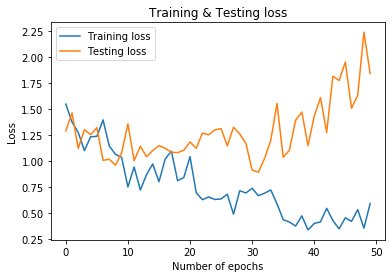

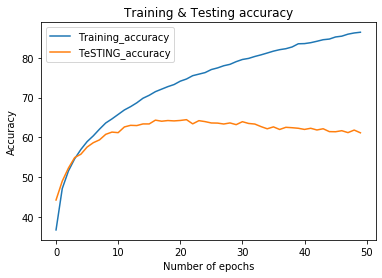

In [16]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur, label='Training_accuracy')
plt.plot(test_accur,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

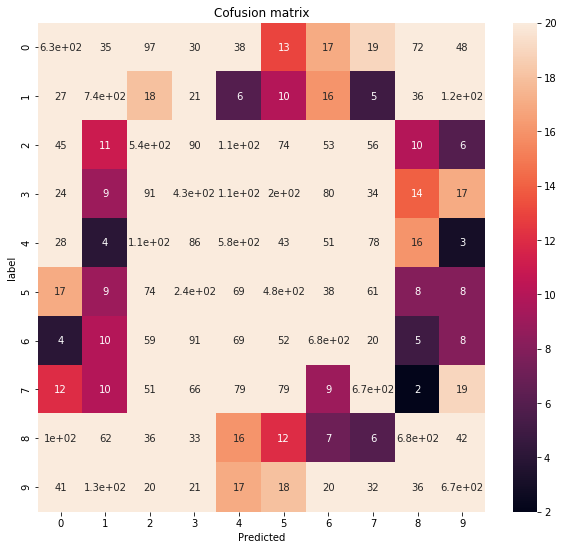

In [17]:
import seaborn as sns
plt.subplots(figsize=(10, 9))
plt.title('Cofusion matrix')
ax = sns.heatmap(conf_matrix, annot=True, vmax=20)
ax.set_xlabel('Predicted');
ax.set_ylabel('label');

### with Data augmentation version 1

In [18]:
transform_train_ver1 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
 
    # hori-flep with prob=0.5
    transforms.RandomHorizontalFlip(),
    
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [19]:
train_data = Cifar10_Dataset(True, transform_train_ver1, target_transform)
print('size of train_data:{}'.format(train_data.__len__()))

test_data = Cifar10_Dataset(False,transform, target_transform)
print('size of test_data:{}'.format(test_data.__len__()))

train_loader = Data.DataLoader(dataset=train_data, batch_size = BATCH_SIZE, shuffle=True)
test_loader  = Data.DataLoader(dataset=test_data, batch_size = 100, shuffle=True)

size of train_data:50000
size of test_data:10000


In [20]:
train_loss_LeNet_aug1 = []
train_accur_LeNet_aug1 = []
test_loss_LeNet_aug1 = []
test_accur_LeNet_aug1 = []
tmp_high_aug1 = 0

save_model_name = 'Cifar-10_LeNet_best_with_aug1.pkl'

print("start training" )
start = time.time()

for epoch in range(1, EPOCH+1):
    print('Epoch: [{}/{}]'.format(epoch, EPOCH) )
    loss_list, accur_list = train_model(model, loss_func, optimizer, epoch, train_loader)
    
    train_loss_LeNet_aug1.append(loss_list)
    train_accur_LeNet_aug1.append(accur_list)
    loss_list  = []
    accur_list = []
    print("Now TESTING!!")
    loss_list, accur_list, conf_matrix, tmp_high_aug1 = evaluate(model, epoch, EPOCH, classes, test_loader, 
                                                            tmp_high_aug1, save_model_name)
    test_loss_LeNet_aug1.append(loss_list)
    test_accur_LeNet_aug1.append(accur_list)
    print(" --> Highest testing value so far：", tmp_high_aug1.item())
    del loss_list
    del accur_list
end = time.time()
print("Excution time：%f sec" % (end - start))

start training
Epoch: [1/50]
 Progress:[**************************************************************************************************** ] 100%, 33.28s Train --> Epoch：1, Loss: 1.3351556062698364, Acc: 51.947998% 
Now TESTING!!
 Test result --> Acc: 61.709999%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 61.709999084472656
Epoch: [2/50]
 Progress:[**************************************************************************************************** ] 100%, 33.49s Train --> Epoch：2, Loss: 1.0463744401931763, Acc: 57.216000% 
Now TESTING!!
 Test result --> Acc: 62.840000%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 62.84000015258789
Epoch: [3/50]
 Progress:[**************************************************************************************************** ] 100%, 33.36s Train --> Epoch：3, Loss: 1.2528859376907349, Acc: 58.854000% 
Now TESTING!!
 Test result --> Acc: 64.989998%
 -> Save the best model & value so far ~
 --> 

 Test result --> Acc: 71.349998%
 Come on, keep going! 
 --> Highest testing value so far： 72.31999969482422
Epoch: [50/50]
 Progress:[**************************************************************************************************** ] 100%, 33.27s Train --> Epoch：50, Loss: 0.8913448452949524, Acc: 69.751999% 
Now TESTING!!
 Test result --> Acc: 71.470001%
 Come on, keep going! 
 Accuracy of each classes
 Test Accuracy of plane: 77.8%, [778/1000]
 Test Accuracy of car: 88.8%, [888/1000]
 Test Accuracy of bird: 69.8%, [698/1000]
 Test Accuracy of cat: 41.0%, [410/1000]
 Test Accuracy of deer: 69.3%, [693/1000]
 Test Accuracy of dog: 62.4%, [624/1000]
 Test Accuracy of frog: 76.2%, [762/1000]
 Test Accuracy of horse: 77.4%, [774/1000]
 Test Accuracy of ship: 78.4%, [784/1000]
 Test Accuracy of truck: 73.6%, [736/1000]
 --> Highest testing value so far： 72.31999969482422
Excution time：1917.643203 sec


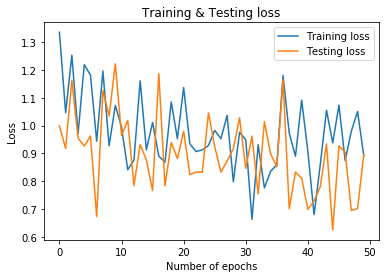

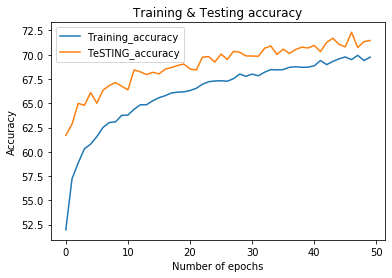

In [21]:
plt.plot(train_loss_LeNet_aug1, label='Training loss')
plt.plot(test_loss_LeNet_aug1,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur_LeNet_aug1, label='Training_accuracy')
plt.plot(test_accur_LeNet_aug1,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### with Data augmentation version 2

In [22]:
transform_train_aug2 = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test_aug2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [23]:
train_data = Cifar10_Dataset(True, transform_train_aug2, target_transform)
print('size of train_data:{}'.format(train_data.__len__()))

test_data = Cifar10_Dataset(False, transform_test_aug2, target_transform)
print('size of test_data:{}'.format(test_data.__len__()))

train_loader = Data.DataLoader(dataset=train_data, batch_size = BATCH_SIZE, shuffle=True)
test_loader  = Data.DataLoader(dataset=test_data, batch_size = 100, shuffle=True)

size of train_data:50000
size of test_data:10000


In [24]:
train_loss_LeNet_aug2 = []
train_accur_LeNet_aug2 = []
test_loss_LeNet_aug2 = []
test_accur_LeNet_aug2 = []

tmp_high_aug2 = 0

save_model_name = 'Cifar-10_LeNet_best_with_aug2.pkl'

print("start training" )
start = time.time()

for epoch in range(1, EPOCH+1):
    print('Epoch: [{}/{}]'.format(epoch, EPOCH) )
    loss_list, accur_list = train_model(model, loss_func, optimizer, epoch, train_loader)
    
    train_loss_LeNet_aug2.append(loss_list)
    train_accur_LeNet_aug2.append(accur_list)
    loss_list  = []
    accur_list = []
    print("Now TESTING!!")
    loss_list, accur_list, conf_matrix, tmp_high_aug2 = evaluate(model, epoch, EPOCH, classes, test_loader, 
                                                            tmp_high_aug2, save_model_name)
    test_loss_LeNet_aug2.append(loss_list)
    test_accur_LeNet_aug2.append(accur_list)
    print(" --> Highest testing value so far：", tmp_high_aug2.item())
    del loss_list
    del accur_list
end = time.time()
print("Excution time：%f sec" % (end - start))

start training
Epoch: [1/50]
 Progress:[**************************************************************************************************** ] 100%, 33.27s Train --> Epoch：1, Loss: 0.7996782064437866, Acc: 67.610001% 
Now TESTING!!
 Test result --> Acc: 70.449997%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 70.44999694824219
Epoch: [2/50]
 Progress:[**************************************************************************************************** ] 100%, 33.27s Train --> Epoch：2, Loss: 0.9985100030899048, Acc: 68.788002% 
Now TESTING!!
 Test result --> Acc: 70.750000%
 -> Save the best model & value so far ~
 --> Highest testing value so far： 70.75
Epoch: [3/50]
 Progress:[**************************************************************************************************** ] 100%, 32.99s Train --> Epoch：3, Loss: 0.8839373588562012, Acc: 68.907997% 
Now TESTING!!
 Test result --> Acc: 70.509995%
 Come on, keep going! 
 --> Highest testing value so far： 7

 Test result --> Acc: 72.139999%
 Come on, keep going! 
 --> Highest testing value so far： 72.27999877929688
Epoch: [26/50]
 Progress:[**************************************************************************************************** ] 100%, 33.51s Train --> Epoch：26, Loss: 0.8817428350448608, Acc: 70.487999% 
Now TESTING!!
 Test result --> Acc: 71.299995%
 Come on, keep going! 
 --> Highest testing value so far： 72.27999877929688
Epoch: [27/50]
 Progress:[**************************************************************************************************** ] 100%, 33.13s Train --> Epoch：27, Loss: 0.836922824382782, Acc: 70.723999% 
Now TESTING!!
 Test result --> Acc: 71.500000%
 Come on, keep going! 
 --> Highest testing value so far： 72.27999877929688
Epoch: [28/50]
 Progress:[**************************************************************************************************** ] 100%, 33.20s Train --> Epoch：28, Loss: 0.6938177347183228, Acc: 70.736000% 
Now TESTING!!
 Test result --> 

 Test result --> Acc: 72.650002%
 Come on, keep going! 
 Accuracy of each classes
 Test Accuracy of plane: 75.1%, [751/1000]
 Test Accuracy of car: 86.9%, [869/1000]
 Test Accuracy of bird: 58.8%, [588/1000]
 Test Accuracy of cat: 42.5%, [425/1000]
 Test Accuracy of deer: 68.9%, [689/1000]
 Test Accuracy of dog: 69.1%, [691/1000]
 Test Accuracy of frog: 80.6%, [806/1000]
 Test Accuracy of horse: 81.2%, [812/1000]
 Test Accuracy of ship: 86.6%, [866/1000]
 Test Accuracy of truck: 76.8%, [768/1000]
 --> Highest testing value so far： 72.86000061035156
Excution time：1921.190867 sec


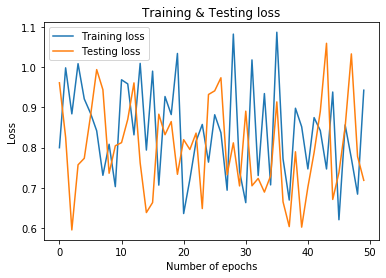

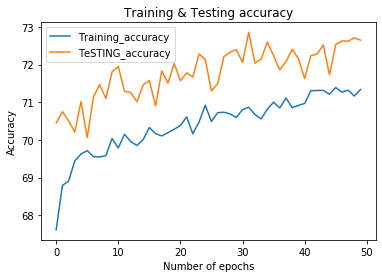

In [25]:
plt.plot(train_loss_LeNet_aug2, label='Training loss')
plt.plot(test_loss_LeNet_aug2,  label='Testing loss')
plt.title('Training & Testing loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_accur_LeNet_aug2, label='Training_accuracy')
plt.plot(test_accur_LeNet_aug2,  label='TeSTING_accuracy')
plt.title('Training & Testing accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Compare Result

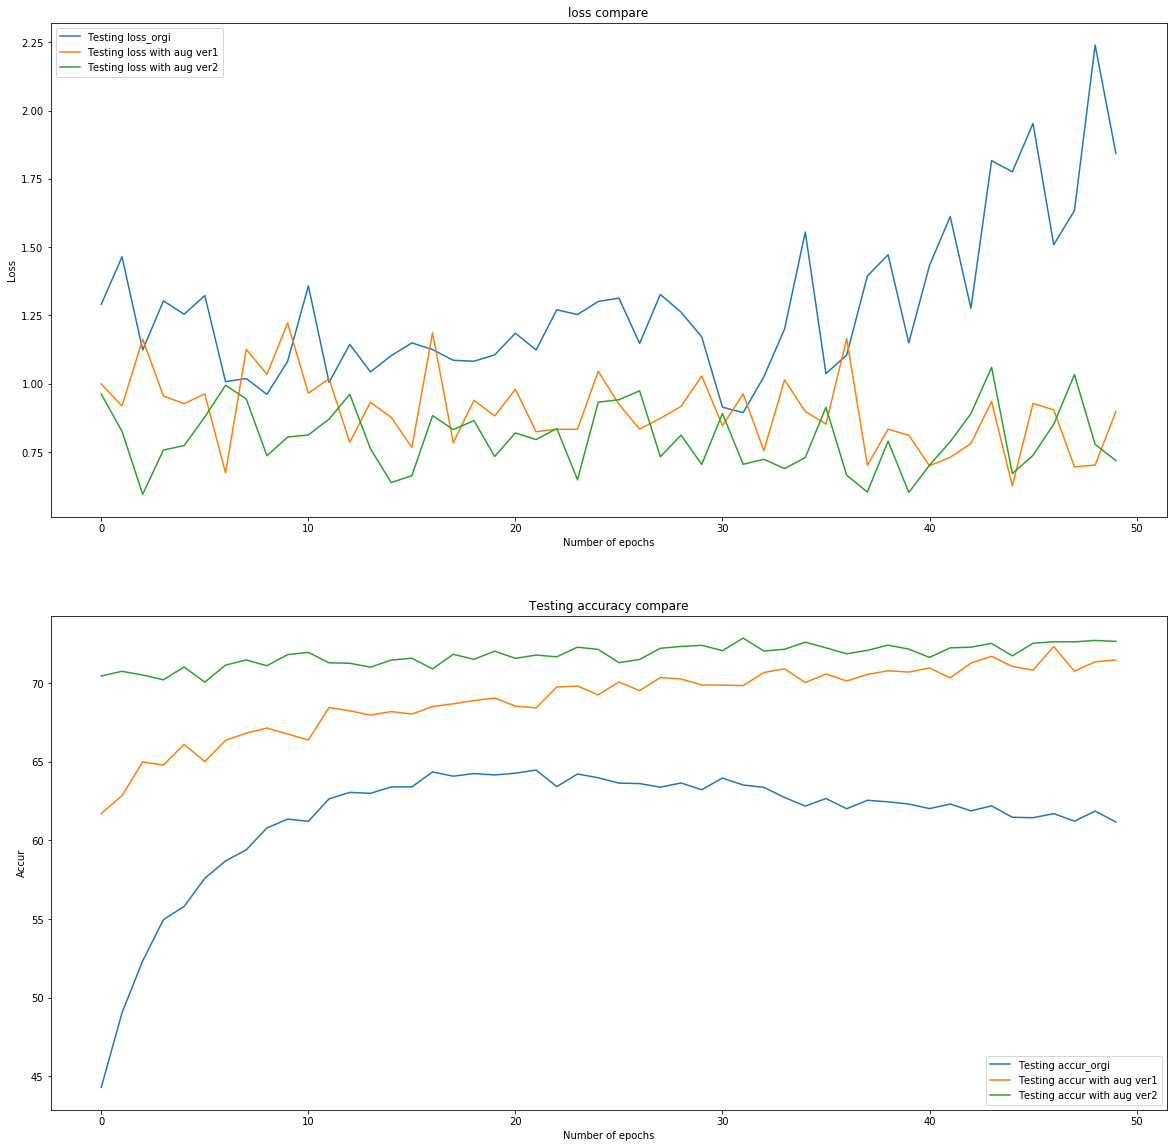

In [26]:
fig = plt.figure(figsize=(20, 20))

plt.subplot(2, 1, 1)
plt.plot(test_loss, label='Testing loss_orgi')
plt.plot(test_loss_LeNet_aug1, label='Testing loss with aug ver1')
plt.plot(test_loss_LeNet_aug2, label='Testing loss with aug ver2')
plt.title('loss compare')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(test_accur, label='Testing accur_orgi')
plt.plot(test_accur_LeNet_aug1, label='Testing accur with aug ver1')
plt.plot(test_accur_LeNet_aug2, label='Testing accur with aug ver2')
plt.title('Testing accuracy compare')
plt.xlabel('Number of epochs')
plt.ylabel('Accur')
plt.legend()

plt.show()

In [28]:
from texttable import Texttable
print("Compare Reult")
tb=Texttable()
tb.set_cols_align(['l', 'c', 'c', 'c'])
tb.set_cols_dtype(['t', 'f', 'f', 'f'])
tb.add_rows([['Version', 'LeNet', 'LeNet with augmentation ver1', 'LeNet with augmentation ver2'],
            ["Best Accuracy (%)", tmp_high.item(), tmp_high_aug1.item(), tmp_high_aug2.item()],
            ])
print(tb.draw())

Compare Reult
+-------------------+--------+------------------------+------------------------+
|      Version      | LeNet  |       LeNet with       |       LeNet with       |
|                   |        |   augmentation ver1    |   augmentation ver2    |
+===================+========+========================+========================+
| Best Accuracy (%) | 64.470 |         72.320         |         72.860         |
+-------------------+--------+------------------------+------------------------+
